# Investigating the $R_1$ and $R_2$ numbers introduced in Miyawaki 2022


In [2]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, lapse_moist
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, frierson_sw_optical_depth, frierson_atmospheric_heating
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v, radius_earth
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_mean
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
from scipy.interpolate import UnivariateSpline

In [90]:
exp_dir = 'tau_sweep/aquaplanet/'
var_keep = ['temp', 'sphum', 'height', 'vcomp', 'olr', 'swdn_toa', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc', 'flux_t', 'flux_lhe', 'ps']
tau_lw = 1
exp_dir = 'tau_sweep/aquaplanet/'
exp_name = f"k={str(tau_lw).replace('.','_')}"
ds = isca_tools.load_dataset(exp_dir + exp_name)[var_keep]
namelist = isca_tools.load_namelist(exp_dir + exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau_sw = namelist['two_stream_gray_rad_nml']['atm_abs']

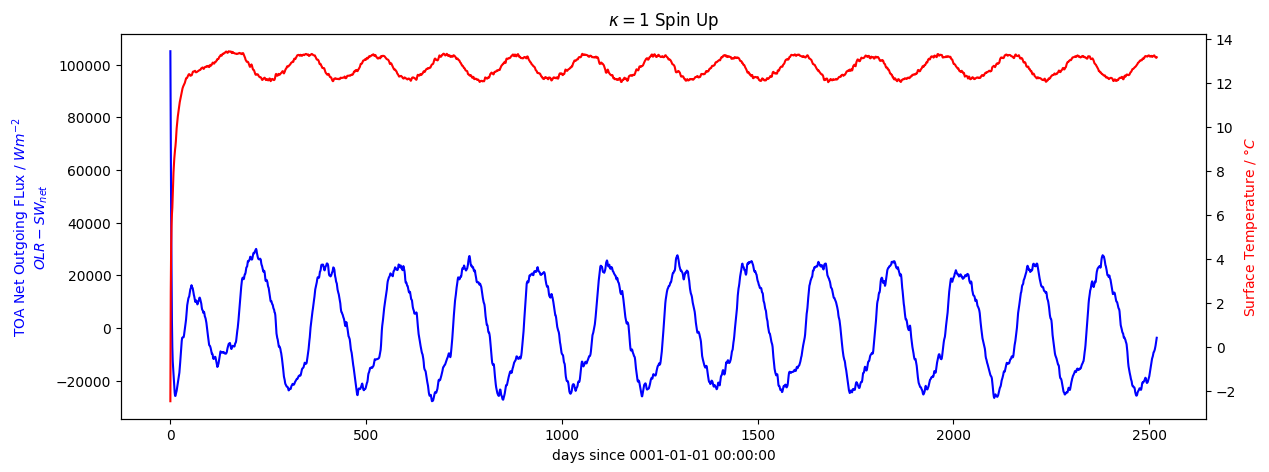

In [91]:
# Plot spin up time
fig, ax = plt.subplots(1,1, figsize=(14, 5))
isca_tools.plot.plot_spin_up(ds.olr, frierson_net_toa_sw_dwn(ds.swdn_toa, ds.ps, albedo, tau_sw),
                             ds.sel(pfull=np.inf, method="nearest").temp, ax)
plt.title(f'$\kappa = {tau_lw}$ Spin Up');

## Test Equation 1 first in the annual zonal mean
Do this so there is no $\partial_t m$ term.

In [92]:
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
ds_use = ds.sel(time=slice(use_time_start, np.inf))

In [93]:
vm = (moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)*1000 * ds_use.vcomp).mean(dim=['time', 'lon']).load()

The plot below shows what we expect i.e. MSE is transferred from the tropics to the poles, this then helps flatten out the temperature gradient.

In [94]:
vm_integ = np.asarray([integrate.simpson(vm[:,i]/g, ds.pfull*100) for i in range(ds.lat.size)])
# Fit a spline to work out the differential
cos_lat = np.asarray(np.cos(np.deg2rad(ds_use.lat)))
spl = UnivariateSpline(np.deg2rad(ds.lat), vm_integ/np.mean(np.abs(vm_integ)), s=0.2)
vm_integ_spline = spl(np.deg2rad(ds.lat)) * np.mean(np.abs(vm_integ))
vm_integ_div_spline = spl.derivative()(np.deg2rad(ds.lat)) * cos_lat/ (radius_earth * cos_lat) * np.mean(np.abs(vm_integ))
vm_integ_div = np.gradient(vm_integ * cos_lat, np.deg2rad(ds.lat))/ (radius_earth * cos_lat)

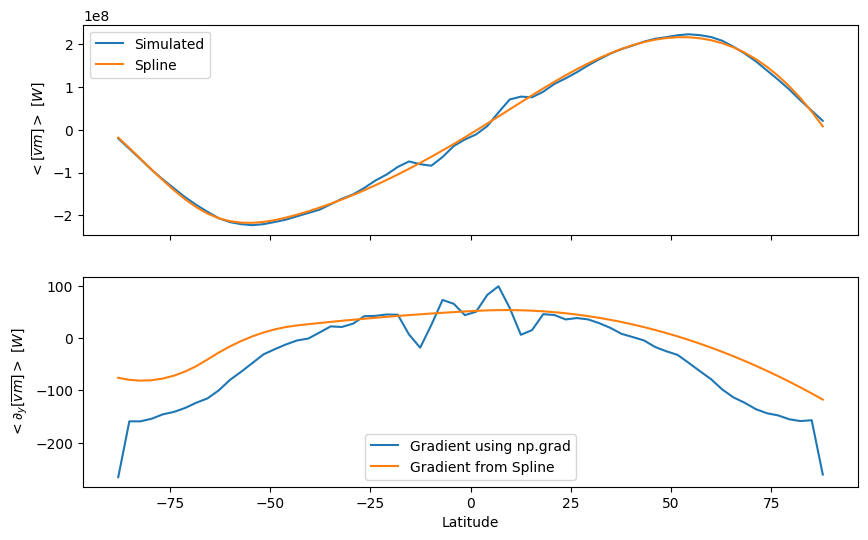

In [95]:
fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True)
ax[0].plot(ds.lat, vm_integ, label='Simulated')
ax[0].plot(ds.lat, vm_integ_spline, label='Spline')
ax[1].plot(ds.lat, vm_integ_div, label='Gradient using np.grad')
ax[1].plot(ds.lat, vm_integ_div_spline, label='Gradient from Spline')
ax[1].set_xlabel('Latitude')
ax[0].set_ylabel('$<[\overline{vm}]>$ [$W$]')
ax[1].set_ylabel('$<\\partial_y [\overline{vm}]>$ [$W$]')
ax[0].legend()
ax[1].legend();

The meridional transport of MSE below, looks a bit strange. We would expect convergence of MSE at the surface - $vm>0$ for $\phi < 0$,
and then divergence at the top of the Hadley cell, $vm<0$ for $\phi < 0$, taking energy away from the tropics.

We see the latter, but not so much the surface behaviour, and there seems to be something weird going on at around 600 hPa.

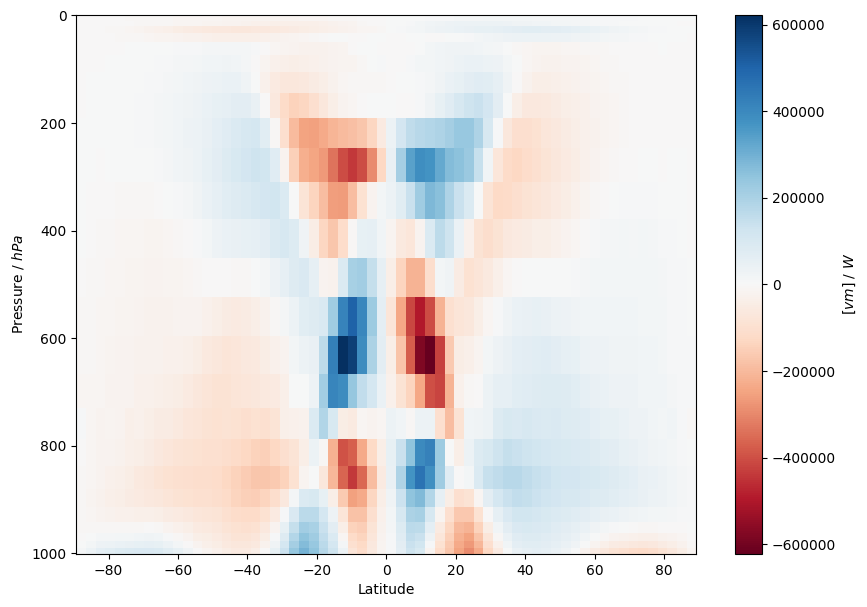

In [98]:
fig, ax = plt.subplots(1,1, figsize=(10, 7))
im = ax.pcolormesh(vm.lat, vm.pfull, vm, cmap='RdBu')
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label='$[vm]$ / $W$')
ax.set_xlabel('Latitude')
ax.set_ylabel('Pressure / $hPa$');

In [47]:
R_a_time_mean = frierson_atmospheric_heating(ds_use, albedo)
R_a_time_mean = R_a_time_mean.mean(dim=['lon', 'time'])

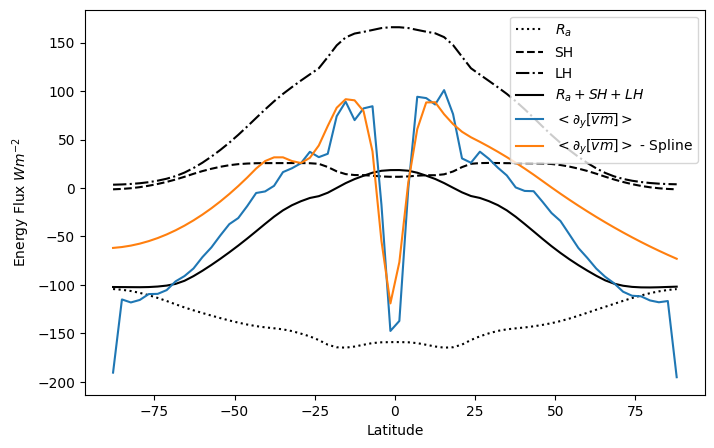

In [85]:
fig, ax = plt.subplots(1,1, figsize=(8, 5), sharex=True)
ax.plot(ds.lat, R_a_time_mean, label='$R_a$', color='k', linestyle=':')
ax.plot(ds.lat, ds_use.flux_t.mean(dim=['lon', 'time']), label='SH', color='k', linestyle='--')
ax.plot(ds.lat, ds_use.flux_lhe.mean(dim=['lon', 'time']), label='LH', color='k', linestyle='-.')
ax.plot(ds.lat, R_a_time_mean + ds_use.flux_t.mean(dim=['lon', 'time']) + ds_use.flux_lhe.mean(dim=['lon', 'time']),
        color='k', label='$R_a + SH + LH$')
ax.plot(ds.lat, vm_integ_div, label='$<\\partial_y [\overline{vm}]>$')
ax.plot(ds.lat, vm_integ_div_spline, label='$<\\partial_y [\overline{vm}]>$ - Spline')
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Energy Flux $Wm^{-2}$');

From the above plot, we see that the equation $<\partial_y [\overline{vm}]> = R_a + SH + LH$ is not exactly satisfied, but with the spline it does a pretty decent job.

This may be something to do how I integrated or differentiated e.g. not taking the correct pressure limits in the vertical integral. I think we expect convergence at bottom of atmosphere and divergence of MSE at top, so this may cause issues, if these don't cancel.

The blue line being bad at high latitudes is probably because you are dividing by $\cos(\phi)$ which is very small.

For actually getting the $R_1$ and $R_2$ values from now on, we infer $\partial_y(vm)$ from the residual as is done in the paper so equation 2 is always exactly satisfied.

### Sanity check of what `swdn_sfc` is
The plot below just shows that `swdn_sfc` is equal to the incident flux at the surface, ($e^{-\tau_{sw}} \times$ `swdn_toa`), which is equal to the flux incident at top of the atmosphere (`swdn_toa`) multiplied by the transmittance of the atmosphere ($e^{-\tau_{sw}}$).
The amount reflected by the surface ($\alpha \times$ incident flux) is then subtracted from this to give `swdn_sfc` = $(1-\alpha) e^{-\tau_{sw}} \times $ `swdn_toa`.

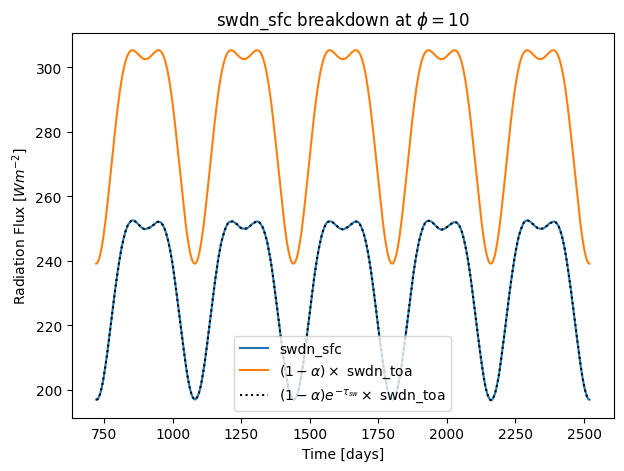

In [11]:
# Sanity check that swdn_sfc includes the albedo term
lat_plot = 10
fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.plot(ds_use.time, ds_use.sel(lat=10, method='nearest').swdn_sfc.mean(dim='lon'), label='swdn_sfc')
ax.plot(ds_use.time, (1-albedo)*ds_use.sel(lat=lat_plot, method='nearest').swdn_toa.mean(dim='lon'), label='$(1-\\alpha) \\times$ swdn_toa')
ax.plot(ds_use.time, (1-albedo)*ds_use.sel(lat=lat_plot, method='nearest').swdn_toa.mean(dim='lon')*
        np.exp(-frierson_sw_optical_depth(ds_use.sel(lat=lat_plot, method='nearest').mean(dim='lon').ps, tau_sw)),
        label='$(1-\\alpha) e^{-\\tau_{sw}} \\times $ swdn_toa', linestyle=':', color='k')
ax.set_ylabel('Radiation Flux [$Wm^{-2}$]')
ax.set_xlabel('Time [days]')
ax.set_title(f'swdn_sfc breakdown at $\phi={lat_plot}$')
ax.legend();

In [12]:
# Get rid of vcomp and ps as don't need anymore and save memory
ds_use = ds_use[[var for var in var_keep if var not in ['ps', 'vcomp']]]

## Northern Mid-Latitudes and Northern High Latitudes Seasonal variation of $R_1$
Now we take the annual mean for two different latitude regions to see the variation of $R_1$ in each.

In [13]:
lat_min = [40, 80]
lat_max = [60, 90]
regions = ['NH Midlatitudes', 'NH High Latitudes']
n_regions = len(lat_min)
ds_region = []
with tqdm(total=n_regions, position=0, leave=True) as pbar:
    for i in range(n_regions):
        ds_region += [ds_use.where((ds_use.lat <= lat_max[i]) & (ds_use.lat >= lat_min[i]), drop=True)]
        ds_region[i] = area_weight_mean_lat(ds_region[i])
        ds_region[i] = annual_mean(ds_region[i]).load()
        pbar.update(1)

  0%|          | 0/2 [00:00<?, ?it/s]

Variables Averaged: ['temp', 'sphum', 'height', 'olr', 'swdn_toa', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc', 'flux_t', 'flux_lhe']


 50%|█████     | 1/2 [00:17<00:17, 17.22s/it]

Variables Averaged: ['temp', 'sphum', 'height', 'olr', 'swdn_toa', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc', 'flux_t', 'flux_lhe']


100%|██████████| 2/2 [00:34<00:00, 17.00s/it]


### $<[\partial_t m]>$ Computation
To compute $R_1$, we need to compute $<[\partial_t m]>$ first - we see how using a spline smooths this out below.

In [14]:
# zonal mean, vertically integrated MSE and its derivative
dt = 24 * 60**2
mse_integ = {'simulated': [0]*n_regions, 'spline': [0]*n_regions}
dm_dt = {'simulated': [0]*n_regions, 'spline': [0]*n_regions}
for i in range(n_regions):
    mse_integ['simulated'][i], dm_dt['simulated'][i] = get_dmse_dt(ds_region[i].temp, ds_region[i].sphum,
                                                                   ds_region[i].height, ds_region[i].pfull*100,ds_region[i].time*dt)
    mse_integ['spline'][i], dm_dt['spline'][i] = get_dmse_dt(ds_region[i].temp, ds_region[i].sphum, ds_region[i].height,
                                                             ds_region[i].pfull*100,ds_region[i].time*dt, spline_smoothing_factor=0.001)

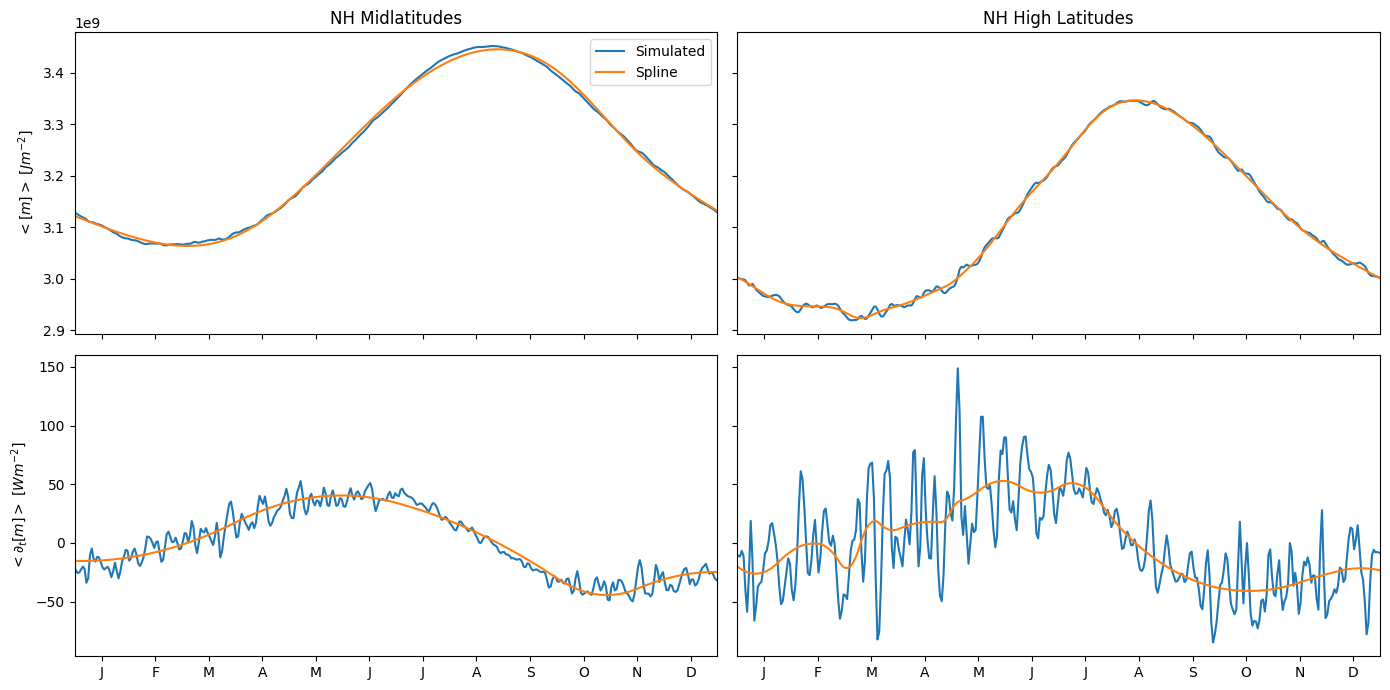

In [15]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

fig, ax = plt.subplots(2,n_regions, figsize=(14, 7), sharex=True, sharey='row')
for i in range(n_regions):
    ax[0,i].plot(ds_region[i].time, mse_integ['simulated'][i], label='Simulated')
    ax[0,i].plot(ds_region[i].time, mse_integ['spline'][i], label='Spline')
    ax[1,i].plot(ds_region[i].time, dm_dt['simulated'][i], label='Simulated')
    ax[1,i].plot(ds_region[i].time, dm_dt['spline'][i], label='Spline')
    ax[1, i].set_xticks(*month_ticks)
    ax[0, i].set_title(regions[i])
ax[0, 0].set_ylabel('$<[m]>$ [$Jm^{-2}$]')
ax[0, 0].legend()
ax[1, 0].set_ylabel('$<\\partial_t [m]>$ [$Wm^{-2}$]')
ax[0, 0].set_xlim(0,360)
plt.tight_layout();

### Figure 5b
Below we replicate figure 5b in the paper, to show the seasonality of the MSE budget in the different regions.

In [16]:
lh = [ds_region[i].flux_lhe.mean(dim=['lon']) for i in range(n_regions)]
sh = [ds_region[i].flux_t.mean(dim=['lon']) for i in range(n_regions)]
R_a = [frierson_atmospheric_heating(ds_region[i], albedo).mean(dim=['lon']) for i in range(n_regions)]
dvm_dy = [get_dvmse_dy(R_a[i], lh[i], sh[i], dm_dt['spline'][i]) for i in range(n_regions)]

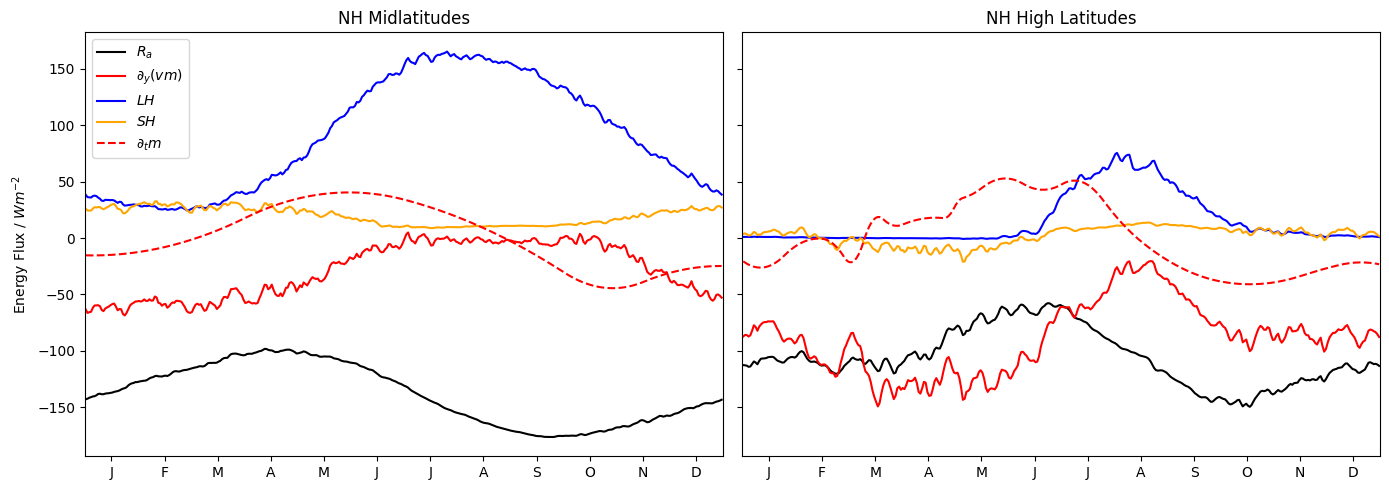

In [17]:
fig, ax = plt.subplots(1,n_regions, figsize=(14, 5), sharey=True, sharex=True)
for i in range(n_regions):
    ax[i].plot(ds_region[i].time, R_a[i], color='k', label='$R_a$')
    ax[i].plot(ds_region[i].time, dvm_dy[i], color='r', label='$\partial_y(vm)$')
    ax[i].plot(ds_region[i].time, lh[i], color='b', label='$LH$')
    ax[i].plot(ds_region[i].time, sh[i], color='orange', label='$SH$')
    ax[i].plot(ds_region[i].time, dm_dt['spline'][i], color='r', linestyle='--', label='$\partial_t m$')
    ax[i].set_title(regions[i])
ax[0].legend()
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Energy Flux / $Wm^{-2}$')
ax[0].set_xlim(0,360)
plt.tight_layout();

### Figure 4
Now we show the seasonal variation of $R_1$ and the lapse rate in each region.

The first plot below is just to check if the fit found by the spline is reasonable.

The plot for the high latitude should be compared to the blue line in figures 9a and 9b in the paper, as both are for aquaplanets with a 5m mixed layer depth. My plots match very well to these which is promising.


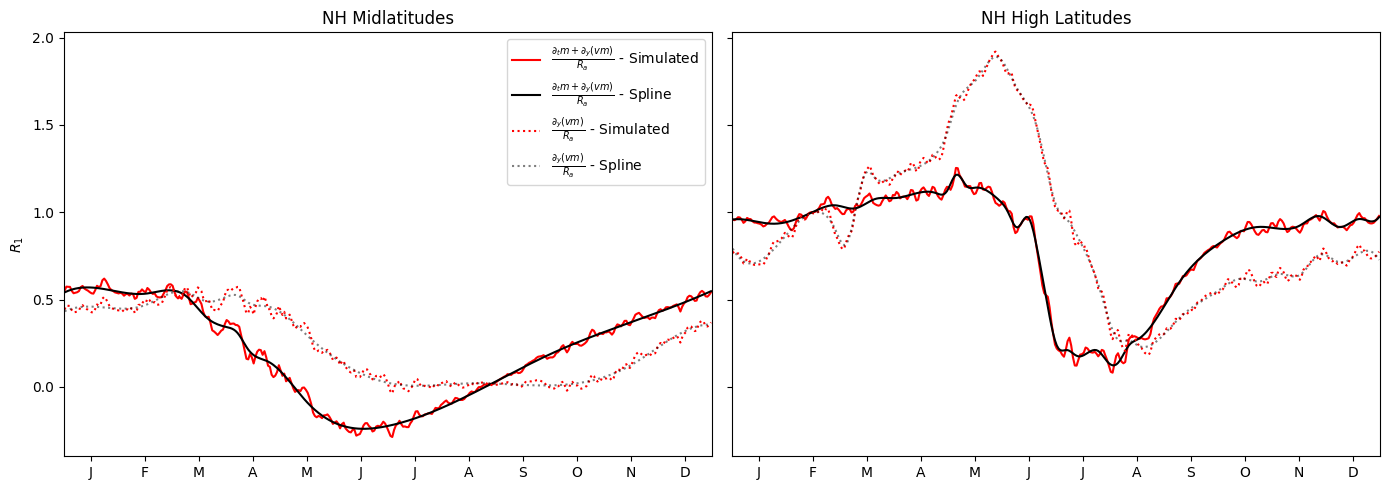

In [18]:
r1 = {'simulated': [get_r1(R_a[i], dm_dt['spline'][i], dvm_dy[i]) for i in range(n_regions)],
      'spline': [get_r1(R_a[i], dm_dt['spline'][i], dvm_dy[i], ds_region[i].time, 0.2) for i in range(n_regions)]}
r1_no_storage = {'simulated': [get_r1(R_a[i], dm_dt['spline'][i]*0, dvm_dy[i]) for i in range(n_regions)],
                 'spline': [get_r1(R_a[i], dm_dt['spline'][i]*0, dvm_dy[i], ds_region[i].time, 0.2) for i in range(n_regions)]}

fig, ax = plt.subplots(1,n_regions, figsize=(14, 5), sharey=True, sharex=True)
for i in range(n_regions):
    ax[i].plot(ds_region[i].time, r1['simulated'][i], color='r', label='$\\frac{\partial_t m + \partial_y(vm)}{R_a}$ - Simulated')
    ax[i].plot(ds_region[i].time, r1['spline'][i], color='k', label='$\\frac{\partial_t m + \partial_y(vm)}{R_a}$ - Spline')
    ax[i].plot(ds_region[i].time, r1_no_storage['simulated'][i], color='r', linestyle=':',
               label='$\\frac{\partial_y(vm)}{R_a}$ - Simulated')
    ax[i].plot(ds_region[i].time, r1_no_storage['spline'][i], color='k', linestyle=':', alpha=0.5,
               label='$\\frac{\partial_y(vm)}{R_a}$ - Spline')
    ax[i].set_title(regions[i])
ax[0].legend()
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$R_1$')
ax[0].set_xlim(0,360)
plt.tight_layout();

In [19]:
# Compute lapse rate deviation from moist adiabat averaged over specific sigma levels
sigma = ds.pfull/ds.pfull[-1]
# only use sigma levels specified in the paper - different for each region
sigma_min = [0.3, 0.9]
sigma_max = [0.7, 1]
use_sigma = [np.logical_and(sigma>=sigma_min[i], sigma<=sigma_max[i]).to_numpy() for i in range(n_regions)]
# Compute lapse rate in pressure coordinates i.e. dT/dp as can do using single line using np.gradient because pfull is the same for all
# times and longitudes.
lapse_actual_array = [np.gradient(ds_region[i].temp, ds_region[i].pfull*100, axis=1)[:, use_sigma[i]]
                      for i in range(n_regions)]
lapse_moist_array = [lapse_moist(ds_region[i].temp, ds_region[i].pfull*100, pressure_coords=True)[:, use_sigma[i]]
                     for i in range(n_regions)]
lapse_dev = [100*(lapse_moist_array[i] - lapse_actual_array[i])/lapse_moist_array[i] for i in range(n_regions)]

# #Proper way to compute lapse rate but takes longer as have to iterate over time and longitudes
# lapse_moist_array2 = [lapse_moist(ds_region[i].temp, ds_region[i].pfull*100)[:, use_sigma[i]]
#                      for i in range(n_regions)]
# lapse_actual_array2 = [np.zeros(lapse_moist_array[i].shape) for i in range(n_regions)]
# with tqdm(total=n_regions*lapse_actual_array[0].shape[0]*lapse_actual_array[0].shape[2], position=0, leave=True) as pbar:
#     for k in range(n_regions):
#         for i in range(lapse_actual_array[0].shape[0]):
#             for j in range(lapse_actual_array[0].shape[2]):
#                 lapse_actual_array2[k][i, :, j] = -np.gradient(ds_region[k].temp[i,:,j], ds_region[k].height[i,:,j])[use_sigma[k]]
#                 pbar.update(1)
# lapse_dev2 = [100*(lapse_moist_array2[i] - lapse_actual_array2[i])/lapse_moist_array2[i] for i in range(n_regions)]

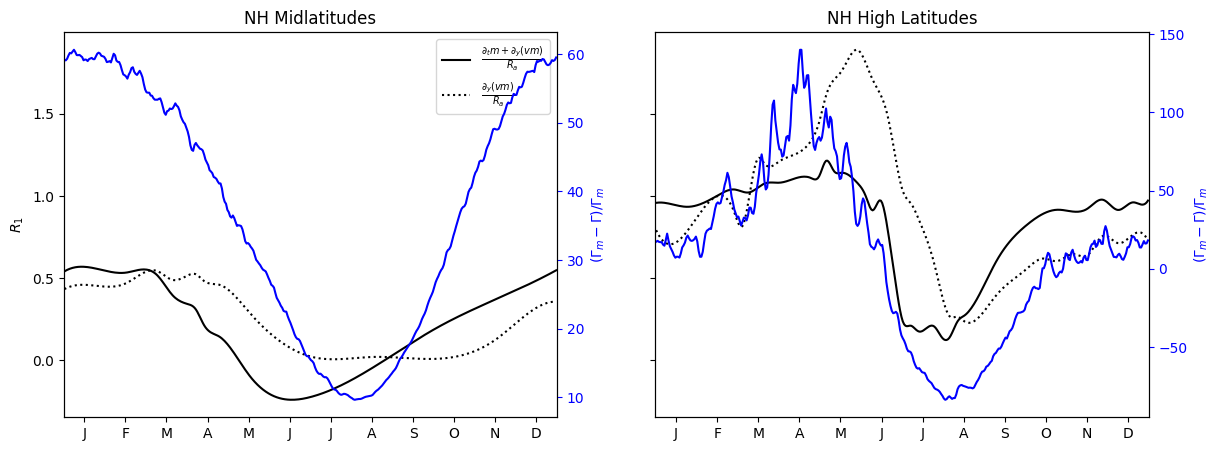

In [20]:
fig, ax = plt.subplots(1,n_regions, figsize=(14, 5), sharey=True, sharex=True)
for i in range(n_regions):
    ax[i].plot(ds_region[i].time, r1['spline'][i], color='k', label='$\\frac{\partial_t m + \partial_y(vm)}{R_a}$')
    ax[i].plot(ds_region[i].time, r1_no_storage['spline'][i], color='k', linestyle=':',
               label='$\\frac{\partial_y(vm)}{R_a}$')
    ax2 = ax[i].twinx()
    ax2.plot(ds_region[i].time, lapse_dev[i].mean(axis=(1,2)), color='b')
    ax2.set_ylabel('$(\Gamma_m - \Gamma)/\Gamma_m$', color='b')
    ax2.tick_params(axis='y', colors='b')
    ax[i].set_title(regions[i])
ax[0].legend()
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$R_1$')
ax[0].set_xlim(0,360);

## Variation as a function of latitude
Next, we compute $R_1$ at each latitude and see how the time average value of $R_1$ varies with latitude, as in Figure 2.

We also replicate Figure 3 which shows the seasonal variation of $R_1$ at each latitude. In both plots, we also include the deviation of the lapse rate from the moist adiabatic value.

In [21]:
ds_all_lat = annual_mean(ds_use).mean(dim='lon').load()  # take zonal mean straight away

In [22]:
# Compute the r1 variable at each latitude for all times in a year
dm_dt_all_lat = np.zeros((ds_all_lat.time.size, ds_all_lat.lat.size))
for i in tqdm(range(ds_all_lat.lat.size)):
    dm_dt_all_lat[:, i] = get_dmse_dt(ds_all_lat.temp[:,:,i], ds_all_lat.sphum[:,:,i], ds_all_lat.height[:,:,i],
                                      ds_all_lat.pfull*100,ds_all_lat.time*dt)[1]
R_a_all_lat = frierson_atmospheric_heating(ds_all_lat, albedo)
dvm_dy_all_lat = get_dvmse_dy(R_a_all_lat, ds_all_lat.flux_lhe, ds_all_lat.flux_t, dm_dt_all_lat)
r1_all_lat = get_r1(R_a_all_lat, dm_dt_all_lat, dvm_dy_all_lat)

100%|██████████| 64/64 [00:00<00:00, 728.39it/s]


In [23]:
sigma_min_all_lat = [0.3, 0.9]
sigma_max_all_lat = [0.7, 1]
use_sigma_all_lat = [np.logical_and(sigma>=sigma_min_all_lat[i], sigma<=sigma_max_all_lat[i]).to_numpy()
                     for i in range(len(sigma_max_all_lat))]

lapse_actual_array_all_lat = np.gradient(ds_all_lat.temp, ds_all_lat.pfull*100, axis=1)
lapse_moist_array_all_lat = lapse_moist(ds_all_lat.temp, ds_all_lat.pfull*100, pressure_coords=True)
lapse_dev_all_lat = 100*(lapse_moist_array_all_lat - lapse_actual_array_all_lat)/lapse_moist_array_all_lat
lapse_dev_all_lat = [lapse_dev_all_lat[:, use_sigma_all_lat[i]].mean(dim='pfull') for i in range(len(sigma_max_all_lat))]

### Figure 2
The version of Figure 2 below shows that we never enter the region of radiative-advective equilibrium ($R_1 > 0.9$ in blue), even at high latitudes, in contrast to what is shown in the paper.

However, the latitude range that we are in radiative-convective equilibrium ($R_1 < 0.1$, shown in orange), does match that shown in the paper.

The lapse rate deviation in the top plot matches pretty well what is shown in the paper. In the second plot, it matches well except at high latitudes, where it is not positive enough. But it does match the trend in $R_1$ very well, so this may be just because advection does not seem to be so important in these aquaplanet simulations.

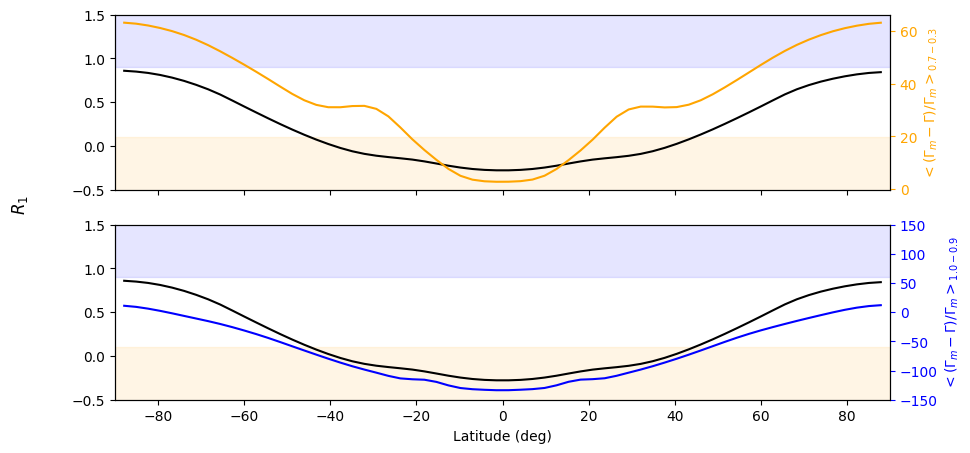

In [24]:
fig, ax = plt.subplots(2,1, figsize=(10, 5), sharey=True, sharex=True)
ax[0].plot(ds_all_lat.lat, r1_all_lat.mean(dim='time'), color='k')
ax2 = ax[0].twinx()
ax2.plot(ds_all_lat.lat, lapse_dev_all_lat[0].mean(dim='time'), color='orange')
ax2.set_ylabel('$<(\Gamma_m - \Gamma)/\Gamma_m>_{0.7-0.3}$', color='orange')
ax2.tick_params(axis='y', colors='orange')
ax[1].plot(ds_all_lat.lat, r1_all_lat.mean(dim='time'), color='k')
ax2 = ax[1].twinx()
ax2.plot(ds_all_lat.lat, lapse_dev_all_lat[1].mean(dim='time'), color='b')
ax2.set_ylabel('$<(\Gamma_m - \Gamma)/\Gamma_m>_{1.0-0.9}$', color='b')
ax2.tick_params(axis='y', colors='b')
ax2.set_ylim(-150,150)
fig.supylabel('$R_1$')
ax[1].set_xlabel('Latitude (deg)')
for i in range(2):
    ax[i].fill_between([-90, 90], [-1,-1], [0.1, 0.1], color='orange', alpha=0.1)
    ax[i].fill_between([-90, 90], [0.9,0.9], [2, 2], color='blue', alpha=0.1)
    ax[0].set_xlim(-90,90)
ax[0].set_ylim(-0.5, 1.5);

### Figure 3
The plot below shows a greater seasonal cycle in all three plots than that shown in the paper. This is not too suprisingly when we look at Figure 7b in the paper which shows that the seasonality increases as the mixed layer depth decreases. This simulation has a mixed layer depth of 5m, which has a large seasonal cycle in that plot (green line).

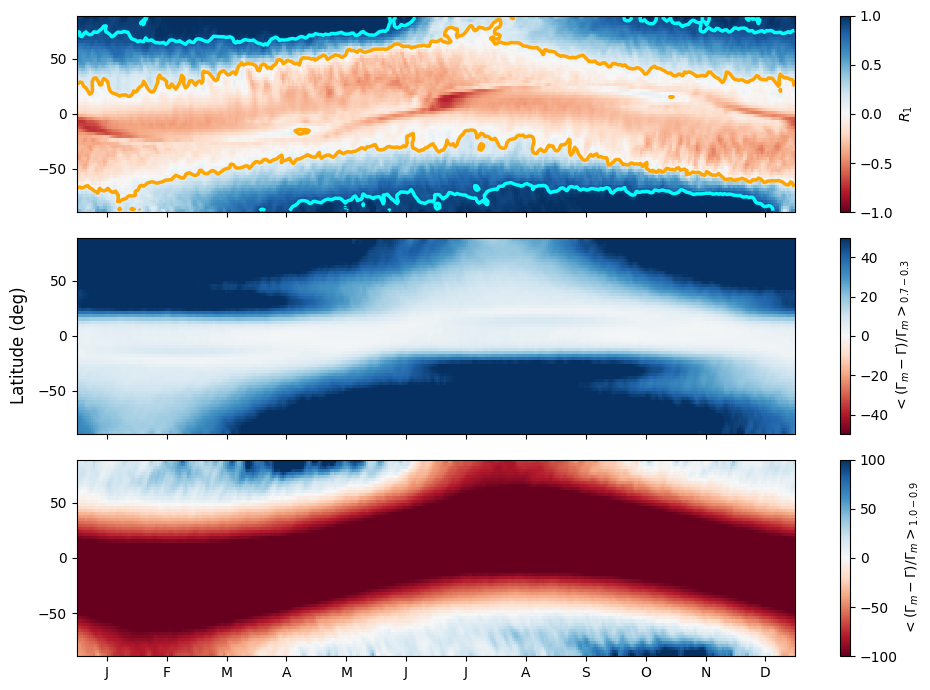

In [25]:
fig, ax = plt.subplots(3,1, figsize=(10, 7), sharey=True, sharex=True)
im = ax[0].pcolormesh(ds_all_lat.time, ds_all_lat.lat, r1_all_lat.transpose(), cmap='RdBu', vmin=-1, vmax=1)
ax[0].contour(ds_all_lat.time, ds_all_lat.lat, r1_all_lat.transpose(), [0.1,0.9], colors=['orange', 'cyan'],
              linewidths=2.5)
plt.colorbar(im, ax=ax[0], label='$R_1$')
im = ax[1].pcolormesh(ds_all_lat.time, ds_all_lat.lat, lapse_dev_all_lat[0].transpose(), cmap='RdBu', vmin=-50, vmax=50)
plt.colorbar(im, ax=ax[1], label='$<(\Gamma_m - \Gamma)/\Gamma_m>_{0.7-0.3}$')
im = ax[2].pcolormesh(ds_all_lat.time, ds_all_lat.lat, lapse_dev_all_lat[1].transpose(), cmap='RdBu', vmin=-100, vmax=100)
plt.colorbar(im, ax=ax[2], label='$<(\Gamma_m - \Gamma)/\Gamma_m>_{1.0-0.9}$')

ax[0].set_xticks(*month_ticks)
fig.supylabel('Latitude (deg)')
plt.tight_layout();

## Surface vs Free Troposphere MSE for hot days
Below, for each latitude region, I plot the surface MSE, $h$, against the free troposphere saturated MSE, $h_{FT}^*$ averaged over the hottest 5% of days. I colour this by the $R_1$ value averaged over the same days.

I compute $R_1$ for each time, at each latitude and longitude, and then average only over days, latitude, longitude corresponding to these hottest days in the same region.

In [26]:
def get_r1_from_ds(dataset):
    # Compute the r1 variable at each latitude and longitude for all times in a year
    dm_dt = np.zeros([dataset.sizes[d] for d in dataset.sizes.keys() if d != 'pfull'])
    with tqdm(total=dataset.lat.size, position=0, leave=True) as pbar:
        for i in range(dataset.lat.size):
                dm_dt[:, i, :] = get_dmse_dt(dataset.temp[:,:,i], dataset.sphum[:,:,i], dataset.height[:,:,i],
                                             dataset.pfull*100, dataset.time*dt, zonal_mean=False)[1]
                pbar.update()
    R_a = frierson_atmospheric_heating(dataset, albedo)
    dvm_dy = get_dvmse_dy(R_a, dataset.flux_lhe, dataset.flux_t, dm_dt)
    return get_r1(R_a, dm_dt, dvm_dy)

In [27]:
ds_use = ds_use.load()   # need to load in dataset otherwise very slow

In [28]:
r1_all = get_r1_from_ds(ds_use)         # r1 for each time, latitude and longitude coordinate

100%|██████████| 64/64 [00:04<00:00, 13.03it/s]


In [29]:
pressure_ft = 500 # free troposphere pressure level in hPa
ft_ind = np.argmin(np.abs(ds_use.pfull.to_numpy()-pressure_ft))

def get_quant_ind(dataset, percentile):
    # Function to find indices in dataset corresponding to surface temperature above a given quantile
    quantile_thresh = dataset.temp[-1].quantile(percentile/100, dim='lon_lat_time', keep_attrs=True)
    quant_ind = np.where(dataset.temp[-1] > quantile_thresh)[0]
    return quant_ind

def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1+w_sat)
    return q_sat

def get_mse_sat_ft(temp, height):
    return moist_static_energy(temp, sphum_sat(temp, pressure_ft*100), height)


In [30]:
quantile_use = 95
lat_width = 10
lat_min = np.arange(0, 90, lat_width)
lat_max = lat_min + lat_width
lat_centre = lat_min + lat_width/2  # Central absolute latitude for given latitude bin
n_lat = len(lat_min)

mse_quant = np.zeros(n_lat)
mse_ft_quant = np.zeros(n_lat)
r1_quant = np.zeros(n_lat)

for i in tqdm(range(n_lat)):
    # Only latitude region
    ds_use2 = ds_use.where((np.abs(ds_use.lat) <= lat_max[i]) & (np.abs(ds_use.lat) >= lat_min[i]), drop=True)
    r1_all_use = r1_all.where((np.abs(ds_use.lat) <= lat_max[i]) & (np.abs(ds_use.lat) >= lat_min[i]), drop=True)
    # Collapse to single coordinate and then take quantile over it
    ds_use2 = ds_use2.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
    r1_all_use = r1_all_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
    # Only above given quantile in temperature
    quantile_thresh = ds_use2.temp[-1].quantile(quantile_use/100, dim='lon_lat_time', keep_attrs=True)
    # Average each variable in data over days where near surface temperature exceeds this quantile
    ds_use2 = ds_use2.where(ds_use2.temp[-1]>=quantile_thresh)
    mse_quant[i] = moist_static_energy(ds_use2.temp[-1], ds_use2.sphum[-1], ds_use2.height[-1]).mean()  # surface MSE
    mse_ft_quant[i] = get_mse_sat_ft(ds_use2.temp[ft_ind], ds_use2.height[ft_ind]).mean()
    r1_quant[i] = r1_all_use.where(ds_use2.temp[-1]>=quantile_thresh).mean(dim='lon_lat_time', skipna=True)
del ds_use2

100%|██████████| 9/9 [01:27<00:00,  9.72s/it]


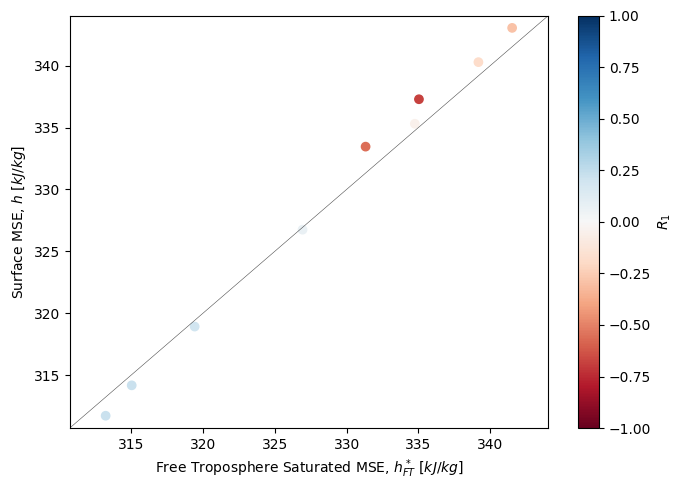

In [31]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))
im = ax.scatter(mse_ft_quant, mse_quant, c=r1_quant, cmap='RdBu', vmin=-1, vmax=1)
ax.set_ylim(np.min([mse_ft_quant.min(), mse_quant.min()])-1, np.max([mse_ft_quant.max(), mse_quant.max()])+1)
ax.set_xlim(np.min([mse_ft_quant.min(), mse_quant.min()])-1, np.max([mse_ft_quant.max(), mse_quant.max()])+1)
ax.plot([0,1],[0,1], transform=ax.transAxes, color='k', alpha=0.7, linewidth=0.4)
ax.set_ylabel('Surface MSE, $h$ [$kJ/kg$]')
ax.set_xlabel('Free Troposphere Saturated MSE, $h_{FT}^*$ [$kJ/kg$]')
fig.colorbar(im, label='$R_1$')
plt.tight_layout();

In the plot above, the value of $R_1$ increases as latitude does i.e. the most negative $R_1$ is the tropics, while the most positive is the polar region.

We see that in general, as $R_1$ increases, $h - h_{FT}^*$ also increases.